# Anomaly Detection using Isolation Forest

## Imports 

In [1]:
from sklearn.ensemble import IsolationForest  
import pandas as pd
import numpy as np
import seaborn as sns
import json
from datetime import datetime, timedelta

## Why the Isolation Forest Model?

The Isolation Forest does not make any assumptions about the data's distribution. This is really important in anomaly detection since anomalies often do not follow the expected distribution.

The Isolation Forest works by isolating anomalies: it randomly selects a feature and a split value to divide the data. Anomalies, which are few and different, require fewer splits to be isolated, making them easier to detect.

Since anomalies are expected to be isolated earlier than normal data, the model naturally identifies them without needing complex calculations.

## Import the CSV file

In [2]:
data = pd.read_csv('clean-data.csv')

## Visualize the data

<Axes: ylabel='pollution'>

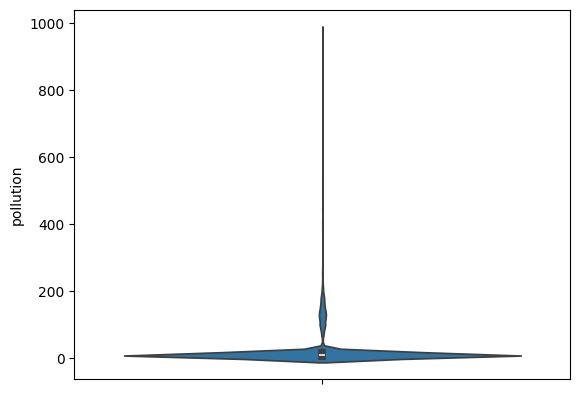

In [3]:
sns.violinplot(data=data, y='pollution')

## Initialize

In [4]:
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.2, random_state=random_state)
clf.fit(data[['pollution']])

IsolationForest(contamination=0.2,
                random_state=RandomState(MT19937) at 0x1FBA78D8840)

In [5]:
data['scores']=clf.decision_function(data[['pollution']])
data['anomaly']=clf.predict(data[['pollution']])
data[['pollution', 'scores', 'anomaly']].head(10)

,pollution,scores,anomaly
0,3.842857,0.039592,1
1,10.712200,0.047716,1
2,4.924336,0.064602,1
3,13.448654,0.040416,1
4,3.481111,0.026032,1
5,9.491667,0.037489,1
6,2.834000,0.004085,1
7,7.081864,0.061417,1
8,2.200000,-0.002108,-1
9,5.600000,0.069434,1


The predicted anomalies values would be -1 and their scores will be negative.

In [6]:
anomaly_pollution=data.loc[data['anomaly']==-1]
anomaly_index=list(anomaly_pollution.index)
anomaly_pollution[['pollution', 'scores', 'anomaly']] 

,pollution,scores,anomaly
8,2.200000,-0.002108,-1
12,132.536129,-0.166973,-1
13,121.685429,-0.164581,-1
20,18.380189,-0.005211,-1
21,23.714848,-0.078914,-1
...,...,...,...
30978,2.500000,-0.002850,-1
30985,18.518333,-0.005391,-1
30992,18.838140,-0.007149,-1
30995,1.889167,-0.018111,-1


## Evaluate the model

In [15]:
outliers_counter = len(data[data['pollution'] > 16])
outliers_counter

6202

## Calculate the accuracy

In [16]:
print("Accuracy percentage:", 100*list(data['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 99.2421799419542


### Based on the anomaly values, create a notification

### Import the forecast values 

In [9]:
with open('forecasts.json') as f:
    forecasts = json.load(f)

### Check if the forecasted value is higher than the outlier value and save the message to a JSON file

In [17]:
df = pd.DataFrame(forecasts) # Make the dictionary a DataFrame  
notifications = []
notification_id = 1
 
# Get only the data from the last hour to create the notifications
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df.set_index('timestamp', inplace=True)
 
current_time = datetime.now() 
last_hour_start = current_time - timedelta(hours=1) 

filtered_data = df[df.index >= last_hour_start]
 
for index, row in filtered_data.iterrows():
    if row['pollution'] > 16:
        message = f"Pollution level is high. Forecasted pollution level is {row['pollution']} at {row['latitude']} {row['longitude']}."
        
        notification = {
            "id": notification_id,
            "message": message
        }

        notifications.append(notification)
        notification_id += 1
        
print(len(notifications))
        
with open('notification.json', 'w') as file:
    json.dump(notifications, file, indent=4)

267
